In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd

# Load data

In [3]:
file = "/Users/danichao/Dani_code/python_39/Luta_waiting_time_hypothesis/data_waiting_time.txt"
data = pd.read_csv(file, header=None, names=['date-time', 'waiting_time'])
data

,date-time,waiting_time
0,20240415-0908,4:54
1,20240416-0910,2:42
2,20240418-0910,3:04
3,20240419-0915,1:39
4,20240429-0901,1:50
5,20240430-0906,1:25
6,20240502-0905,3:37
7,20240503-0908,2:17
8,20240516-0914,1:45
9,20240517-0912,2:12


In [4]:
data.dtypes

date-time       object
waiting_time    object
dtype: object

# Data cleaning

In [5]:
# convert the time into seconds
def to_seconds(x):
    minute, sec = map(float, x.strip().split(':'))
    total_seconds = 60 * minute + sec
    return total_seconds

In [6]:
data['waiting_total_seconds'] = data['waiting_time'].apply(to_seconds)
data

,date-time,waiting_time,waiting_total_seconds
0,20240415-0908,4:54,294.0
1,20240416-0910,2:42,162.0
2,20240418-0910,3:04,184.0
3,20240419-0915,1:39,99.0
4,20240429-0901,1:50,110.0
5,20240430-0906,1:25,85.0
6,20240502-0905,3:37,217.0
7,20240503-0908,2:17,137.0
8,20240516-0914,1:45,105.0
9,20240517-0912,2:12,132.0


# Exploration

In [7]:
data['waiting_total_seconds'].describe()

count     16.000000
mean     148.062500
std       55.435811
min       85.000000
25%      108.750000
50%      131.500000
75%      167.500000
max      294.000000
Name: waiting_total_seconds, dtype: float64

# Visualize

In [8]:
from matplotlib import pyplot as plt
import seaborn as sns

Text(0.5, 0, 'Waiting time in seconds')

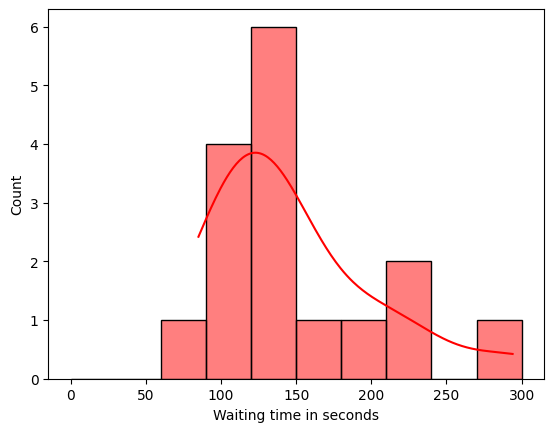

In [9]:
sns.histplot(data=data, x="waiting_total_seconds", binwidth=30, binrange=[0, 300], kde=True, color='red')
plt.xlabel('Waiting time in seconds')

# Hypothesis testing

Since our sample size is small (< 30), I will use ***T distribution*** and ***T test*** to calculate confidence interval and to compare with coffee waiting time in other places.

Although we are limited by the small size of the sample, we can still have a deeper inspection by comparing the sample distribution with ***normal distribution*** and ***exponential distribution***. The latter is commonly used for statistical studies of ER waiting time.

## T test

In [10]:
from scipy.stats import t
from scipy.stats import ttest_1samp

In [11]:
sample_mean = data['waiting_total_seconds'].describe()['mean']
sample_sigma = data['waiting_total_seconds'].describe()['std']
sample_sem = sample_sigma/(len(data['waiting_total_seconds']))**0.5

In [12]:
# Calculate confidence interval for the underlying population mean of Luta waiting time
lower_bound, upper_bound = \
   t.interval(confidence=0.95, df=len(data['waiting_total_seconds'])-1, loc=sample_mean, scale=sample_sem) 

print('The 95%-confidence interval for the population mean of Luta waiting time (seconds) is in the range between \n({}, {})'.format(lower_bound, upper_bound))

The 95%-confidence interval for the population mean of Luta waiting time (seconds) is in the range between 
(118.52284133682173, 177.60215866317827)


The average coffee waiting time varied when I searched on the internet. ***As long as the collected data of coffee waiting time has an average faster than ~118 seconds or slower than ~178 seconds, we have evidence to reject the hypothese that Luta and them have the same waiting time***.

For example, according to my search, the average coffee waiting time is `3-5 minutes (180-300 seconds)`, which is `out of Luta's 95%-confidence interval`, and we can say ***Luta has a different coffee waiting time than most coffee shops***.

This is equivalent to p-value: ***if p-value is lower than 0.05, then we have evidence to reject the hypothese that Luta and them have the same waiting time***. Taking 3 minutes for the average coffee waiting time among most coffee shops as an example, I calculate the p-value as following.

In [13]:
population_mean = 180  #from collected data
t_statistic, p_value_t = ttest_1samp(data['waiting_total_seconds'], popmean=population_mean)
print('p-value for T test: ', p_value_t)

p-value for T test:  0.03591280863658684


***The p-value is ~0.036, lower than 0.05, showing the evidence that Luta has a different coffee waiting time than most coffee shops.***

## Kolmogorov–Smirnov (K-S) tests

The following analysis is based on an important assumption: ***the distribution of Luta waiting time stays the same when we have large-enough sample size (>30)***.

I will compare this pseudo distribution with normal distribution and exponential distribution, and use `Kolmogorov–Smirnov (K-S) tests` to examine the ***hypothesis that the sample is drawn from normal distribution (exponential distribution)***.

***Note again: the following analysis is nothing but a toy model.***

### Inspection

In [14]:
from scipy.stats import norm
from scipy.stats import expon
from scipy.stats import kstest
from scipy.stats import gaussian_kde

In [15]:
x_points = np.linspace(0, 400, num=10000)

normal_x = norm.pdf(x_points, sample_mean, sample_sigma)
exp_x = expon.pdf(x_points, scale=sample_mean)

norm_sample = norm.rvs(loc=sample_mean, scale=sample_sigma, size=45)
exp_sample = expon.rvs(scale=sample_mean, size=45)

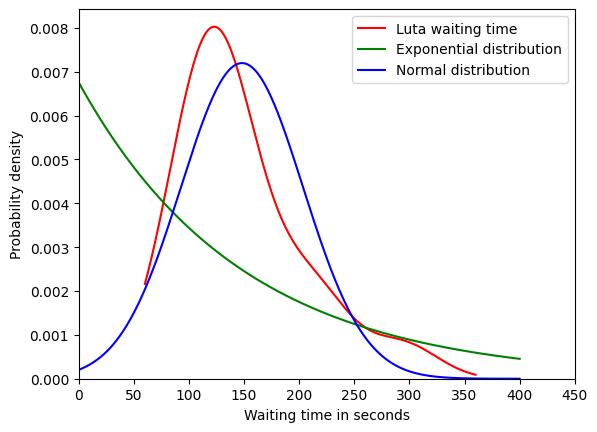

In [16]:
sns.kdeplot(data=data, x="waiting_total_seconds", label='Luta waiting time', clip=[60, 360], color='red')
plt.plot(x_points, exp_x,  label='Exponential distribution', color='green')
plt.plot(x_points, normal_x,  label='Normal distribution', color='blue')
plt.xlabel('Waiting time in seconds')
plt.ylabel('Probability density')
plt.xlim([0,450])
plt.legend()

Apparently, unlike ER waiting time, Luta waiting time is not closed to exponential distribution at all.

### Test results

In [17]:
# Get estimated probability density function (PDF) for Luta waiting time
sample_kde = gaussian_kde(data['waiting_total_seconds'])
sample_kde_points = sample_kde(x_points)

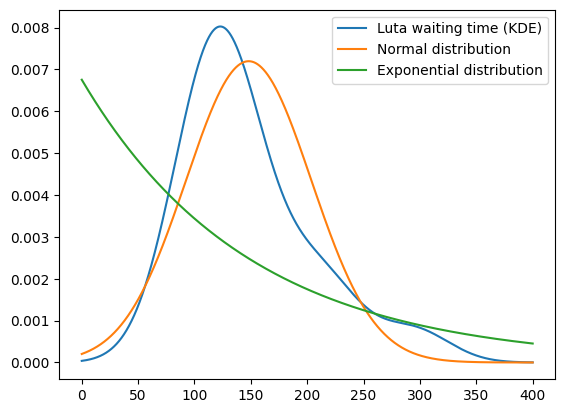

In [18]:
plt.plot(x_points, sample_kde_points, label = 'Luta waiting time (KDE)')
plt.plot(x_points, normal_x, label = 'Normal distribution')
plt.plot(x_points, exp_x, label = 'Exponential distribution')
plt.legend(loc='upper right')

The gaussian-kernel-densitiy estimated PDF (KDE) looks good, as it looks like what seaborn kdeplot gives us.

In [19]:
# First we need to increase our sample size with gaussian-kernel-densitiy estimated PDF
new_sample = sample_kde.resample(15)[0]
sample_kde_points = np.concatenate([data['waiting_total_seconds'].values, new_sample])

In [20]:
new_sample_mean = np.mean(sample_kde_points)
new_sample_sigma = np.std(sample_kde_points)
new_sample_sem = new_sample_sigma/(len(sample_kde_points))**0.5

In [21]:
from scipy.stats import norm
lower_bound, upper_bound = norm.interval(confidence=0.95, loc=new_sample_mean, scale=new_sample_sem)

print('The 95%-confidence interval for the population mean of new mock sample is in the range between \n({}, {})'.format(lower_bound, upper_bound))

The 95%-confidence interval for the population mean of new mock sample is in the range between 
(131.5481757871012, 174.28461391620684)


Since now we have ***sample size > 30***, we can estimate the confidence interval for population mean using normal distribution, which is more common. Now ***if most coffee shops have waiting time faster than ~131 seconds or slower than ~175 seconds, we will have evidence to reject the hypothesis that Luta and them have the same waiting time.***

In [22]:
def KS_report(sample_kde_points, dist_mock):
    test_statistic, p_value = kstest(sample_kde_points, dist_mock)
    print('p-value: ', p_value)
    #print('test statistic: ', test_statistic)

In [23]:
print('K-S test with normal distribution')
KS_report(sample_kde_points, norm_sample)

K-S test with normal distribution
p-value:  0.2701331754264033


In [24]:
print('K-S test with exponential distribution')
KS_report(sample_kde_points, exp_sample)

K-S test with exponential distribution
p-value:  0.0036474939486158


Based on the p-values, we conclude as following:
- `p-value ~0.27, which is higher than 0.05:` As we collect more observations of coffee waiting time at Luta and from normal distribution, sharing the same sample mean and standard deviation, we will ***fail to reject*** statistically that Luta has different waiting time than normal distribution.

- `p-value ~0.003, which is still lower than 0.05:` We still can claim Luta coffee waiting time is different from exponential distribution and are certain that Luta waiting time is different from ER waiting time.
